In [1]:
from ultralytics import YOLO
import cv2
import util
from util import get_car, read_license_plate, write_csv
import matplotlib.pyplot as plt

## CODI MAIN

### 1. Proves amb YOLO

In [14]:
# Ruta de la imagen
image_path = r'\Users\mirvi\Desktop\mii\UAB\4.1\PSIV2\detect mateicules\r1\exemple_front.jpeg'

# Cargar la imagen
image = cv2.imread(image_path)

[[[  0   2   0]
  [  3  10   7]
  [ 11  18  15]
  ...
  [ 35  38  36]
  [ 35  38  36]
  [ 33  36  34]]

 [[  6  13  10]
  [  9  16  13]
  [ 12  19  16]
  ...
  [ 27  30  28]
  [ 27  30  28]
  [ 26  29  27]]

 [[ 11  18  15]
  [ 10  17  14]
  [  9  16  13]
  ...
  [ 19  22  20]
  [ 20  23  21]
  [ 20  23  21]]

 ...

 [[ 98 120 138]
  [103 125 143]
  [119 141 159]
  ...
  [138 154 177]
  [131 147 170]
  [123 139 162]]

 [[ 83 105 123]
  [ 89 111 129]
  [103 125 143]
  ...
  [137 153 176]
  [123 139 162]
  [112 128 151]]

 [[ 90 112 130]
  [ 86 108 126]
  [ 97 119 137]
  ...
  [124 140 163]
  [111 127 150]
  [103 119 142]]]



0: 640x480 1 truck, 167.6ms
Speed: 10.0ms preprocess, 167.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Clase detectada: 7, Confianza: 0.40788403153419495


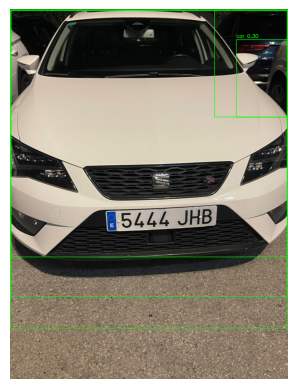

In [16]:
# Cargar el modelo YOLOv8 preentrenado
model = YOLO('yolov8n.pt')  # Puedes cambiar el modelo a yolov8m.pt o yolov8l.pt para más precisión

# Realizar la detección
results = model(image)

# Mostrar resultados y dibujar los bounding boxes
for result in results:
    boxes = result.boxes  # Lista de cuadros detectados
    for box in boxes:
        # Obtener coordenadas de los cuadros detectados
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordenadas del cuadro
        confidence = box.conf[0]  # Confianza del cuadro detectado
        class_id = int(box.cls[0])  # ID de la clase detectada
        
        # Imprimir información de la clase detectada (en este caso, si fuera la matrícula)
        print(f"Clase detectada: {class_id}, Confianza: {confidence}")
        
        # Dibujar el rectángulo del objeto detectado
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f'{model.names[class_id]} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Mostrar la imagen con las detecciones
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## 2. DATASET LOADER

In [1]:
import os
import pandas as pd

# Directorios del dataset
images_dir_train = 'dataset/images/train'
labels_dir_train = 'dataset/labels/train'

images_dir_test = 'dataset/images/val'
labels_dir_test = 'dataset/labels/val'

## TRAIN

# Lista para almacenar la información del dataset
data = []

# Recorrer cada archivo de etiquetas
for label_file in os.listdir(labels_dir_train):
    if label_file.endswith('.txt'):
        # Obtener el nombre base de la imagen correspondiente
        image_file = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_dir_train, image_file)
        
        # Leer el archivo de etiquetas
        with open(os.path.join(labels_dir_train, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                # Suposición de formato: class_id x_min y_min x_max y_max
                class_id, x_min, y_min, x_max, y_max = map(float, line.strip().split())

                # Añadir los datos a la lista
                data.append([image_path, class_id, x_min, y_min, x_max, y_max])

# Crear un DataFrame con las columnas: 'image_path', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max'
df_train = pd.DataFrame(data, columns=['image_path', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max'])

# Guardar el DataFrame en un archivo CSV
csv_path = 'dataset_labels_train.csv'
df_train.to_csv(csv_path, index=False)

# Verificar el CSV creado
print(f"CSV guardado en: {csv_path}")


## TEST

# Lista para almacenar la información del dataset
data = []

# Recorrer cada archivo de etiquetas

for label_file in os.listdir(labels_dir_test):
    if label_file.endswith('.txt'):
        # Obtener el nombre base de la imagen correspondiente
        image_file = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_dir_test, image_file)
        
        # Leer el archivo de etiquetas
        with open(os.path.join(labels_dir_test, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                # Suposición de formato: class_id x_min y_min x_max y_max
                class_id, x_min, y_min, x_max, y_max = map(float, line.strip().split())

                # Añadir los datos a la lista
                data.append([image_path, class_id, x_min, y_min, x_max, y_max])
    
# Crear un DataFrame con las columnas: 'image_path', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max'
df_test = pd.DataFrame(data, columns=['image_path', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max'])

# Guardar el DataFrame en un archivo CSV
csv_path = 'dataset_labels_test.csv'
df_test.to_csv(csv_path, index=False)

# Verificar el CSV creado
print(f"CSV guardado en: {csv_path}")




CSV guardado en: dataset_labels_train.csv
CSV guardado en: dataset_labels_test.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Inicialitza el dataset amb un DataFrame i opcionalment una transformació.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Retorna la quantitat de mostres en el dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retorna una mostra del dataset en l'índex donat (imatge i etiquetes).
        """
        # Obtenir el camí de la imatge i les coordenades del DataFrame
        row = self.dataframe.iloc[idx]
        image_path = row['image_path']
        class_id = row['class_id']
        x_min = row['x_min']
        y_min = row['y_min']
        x_max = row['x_max']
        y_max = row['y_max']

        # Carregar la imatge
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        # Crear el tensor de la caixa delimitadora (bounding box)
        bbox = torch.tensor([class_id, x_min, y_min, x_max, y_max], dtype=torch.float32)
        
        return image, bbox

# Exemple de DataFrame de training
df_train = pd.read_csv('dataset/dataset_labels_train.csv')
df_test = pd.read_csv('dataset/dataset_labels_train.csv')

# Crear datasets a partir dels DataFrames
train_dataset = DataFrameDataset(df_train)
test_dataset = DataFrameDataset(df_test)

# Crear DataLoaders per a training i testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
